# Obtaining High Performance Areas (C4 model)

## Imports

In [1]:
from cobra.io import read_sbml_model
from cobra import flux_analysis
import random
import time
from cobra.flux_analysis import flux_variability_analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Reading and preparing the model

In [2]:
"""
Read and prepare C4 model
"""

c4_model = read_sbml_model("c4_model.xml")

c4_model.solver = "cplex"

c4_model.objective = '[B]_Maize_biomass_tx'

def c4_maintenance(c4_model):
    #Constrains for light dependent maintenance costs
    atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
    photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
    atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
    photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

    const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - atp_b.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_b)

    const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_m)
    # ATP/NADPH 3:1 constraints
    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

#Add Light dependent maintenance
c4_maintenance(c4_model)


#Ensuring directionality of uptake reaction
c4_model.reactions.get_by_id("[B]_Nitrate_tx").bounds = (0, 999999)
c4_model.reactions.get_by_id("[M]_Nitrate_tx").bounds = (0, 999999)
c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0, 999999)
c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0, 999999)


No objective coefficients in model. Unclear what should be optimized


## Performing pFBA

### Determination of biomass flux and absolute sum of fluxes for each of the 9 starting points

In [3]:
"""
Functions to perform the simulation
"""

def c4_simulation(light, N, c4_model):
    ##C4
    with c4_model:
        #Light Uptale constrain
        B_Im_hnu = c4_model.reactions.get_by_id("[B]_Photon_tx")
        M_Im_hnu = c4_model.reactions.get_by_id("[M]_Photon_tx")
        #CONSTRAINT: Total Photon uptake limited to "light" µE
        const_hnu_sum = c4_model.problem.Constraint( B_Im_hnu.flux_expression + M_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_sum)
        #CONSTRAINT: Total Photon uptake by bundle sheath must be less or equal than in mesophyll
        const_hnu_ratio = c4_model.problem.Constraint( M_Im_hnu.flux_expression - B_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_ratio)
        #CONSTRAINT : Total N uptake must not surpass defined upper bound
        m_n = c4_model.reactions.get_by_id("[B]_Nitrate_tx")
        bs_n = c4_model.reactions.get_by_id("[M]_Nitrate_tx")
        const_n_ratio = c4_model.problem.Constraint( bs_n.flux_expression + m_n.flux_expression,
                                               lb = 0, ub = N)
        c4_model.add_cons_vars(const_n_ratio)
        #pFBA
        solution = flux_analysis.pfba(c4_model)
        sum_of_flux = solution.fluxes.abs().sum()
        solution_frame=solution.to_frame()
        growth = solution_frame.loc["[B]_Maize_biomass_tx"]["fluxes"]
        return (sum_of_flux, growth)

In [4]:
"""
Build Dictionary with the combination of Light/Nitrogen conditions as a key,
 and Biomass flux and Sum of fluxes as values
"""

#Grid of light and Nitrogen conditions to use
light_uptake = [100, 250, 500]
nitrogen_uptake = [0.2, 2.5, 6]

#Dictionaries to hold the results
res_c4 = {}

#Perform the simulations for diferent combinations of Light/N and store them in the dictionary
for l in light_uptake:
    for n in nitrogen_uptake:
        res_c4[(l,n)] = c4_simulation(l,n,c4_model)

print(res_c4)



{(100, 0.2): (307.4420941981625, 0.003956163833772798), (100, 2.5): (693.4916382201684, 0.010251688843163097), (100, 6): (693.4916382201677, 0.010251688843163076), (250, 0.2): (307.442094198161, 0.003956163833772799), (250, 2.5): (1749.0675978768968, 0.027368307237520224), (250, 6): (1749.067597876931, 0.027368307237520213), (500, 0.2): (307.4420941981622, 0.0039561638337728055), (500, 2.5): (3012.6684876816153, 0.04945204792215987), (500, 6): (3509.804113504795, 0.05589600456144892)}


## Computation of the High Performance Areas

In order to compute the high performance area for a starting point a technique involving random sampling was devised in order to map out this area. Firstly, flux balance analysis (FVA) was used to estimate the range of possible nitrogen and light uptake values, with the FVA constrained to have at least a sum of fluxes equal to the absolute sum of fluxes of the starting point. This will save us a lot of computation time, by defining a priori the bounds in which random values for nitrogen and light uptake should be generated.

Then, a new pFBA simulation will be performed with the constrains that the biomass value must be at least 80% of the one obtained with the initial pFBA simulation for the starting point, and the sum of fluxes value cannot surpass the one determined for the starting point.

By defining the high performance areas as the range of feasible solutions for the model under the aforementioned constrains for different light and nitrogen uptakes, one of the most logical courses of action in order to map them out would be to perform a lot of simulations with different light and nitrogen uptakes, and store feasible solutions. That is exactly what the code described below performs.

The function will receive the feasible range of uptakes of nitrogen and light from the FVA and use them in functions from the random module of python, which will generate random numbers within those constrains. These values will then be used as a forced flux value for the nitrogen and light uptakes of the simulation. Unfeasible solutions will be ignored, and the algorithm will stop once 500 feasible solutions have been reached.

The are differences in the implementation of this methodology in the C4 model when compared with the C3 model. The main issue is that there are two possible uptake reactions for nitrogen and light each: one in the bundle sheath and one in the mesophyll. 

This adds another level of complexity when using FVA to compute the uptake bounds, as both reactions must be taken into acccount in order to determine total uptake. As such, another function was created in order to handle FVA results and attempt to establish the high performance area bounds for the random simulations. This was only partially successfull though. 

The FVA determined bounds were able to pinpoint the approximate location of the respective high performance area in the 2D solution space, but it wasn't able to fully encompass it. In order to determine the true high performance are, the FVA results were used as a starting point, and then manually expanded untill no more points were included into the HPA. 

In [6]:
"""
Function to perform the FVA at 80% fraction of optimum, restraining the 
sum of fluxes to be at maximum equal to the sum of fluxes of the initial point
"""

def fva_c4(sum_of_flux, c4_model):
        if sum_of_flux is not None:
        #Sum of flux constrain
            coefficients = dict()
            for rxn in c4_model.reactions:
                coefficients[rxn.forward_variable] = 1.
                coefficients[rxn.reverse_variable] = 1.
            constraint = c4_model.problem.Constraint(0, lb=0, ub=sum_of_flux)

            c4_model.add_cons_vars(constraint)
            c4_model.solver.update()
            constraint.set_linear_coefficients(coefficients=coefficients)

        #FVA
        solution = flux_variability_analysis(c4_model, reaction_list=["[B]_Nitrate_tx","[M]_Nitrate_tx", "[B]_Photon_tx", "[M]_Photon_tx"], fraction_of_optimum=0.8)
        return solution


In [7]:
"""
Function to handle FVA outputs
"""

def starting_conditions(initial_point):
    
    n_list = ["[B]_Nitrate_tx","[M]_Nitrate_tx"]
    l_list = ["[B]_Photon_tx", "[M]_Photon_tx"]

    min_n = 99999
    max_n = 0
    min_l = 99999
    max_l = 0
    
    #Handling nitrogen bounds
    for r in n_list:
        with c4_model:
            c4_model.reactions.get_by_id(r).bounds = (0,0)
            res = fva_c4(sum_of_flux =  initial_point[0], c4_model=c4_model)
            if res.iloc[0]["minimum"] < min_n or res.iloc[1]["minimum"] < min_n:
                minimum = max(res.iloc[0]["minimum"], res.iloc[1]["minimum"])
                min_n = min(minimum, min_n)
            if res.iloc[0]["maximum"] > max_n or res.iloc[1]["maximum"] > max_n:
                maximum = max(res.iloc[0]["maximum"], res.iloc[1]["maximum"] )
                max_n = maximum
    
    #Handling light bounds
    for r in l_list:
        with c4_model:
            c4_model.reactions.get_by_id(r).bounds = (0,0)
            res = fva_c4(sum_of_flux =  initial_point[0], c4_model=c4_model)
            if res.iloc[2]["minimum"] < min_l or res.iloc[3]["minimum"] < min_l:
                minimum = max(res.iloc[2]["minimum"], res.iloc[3]["minimum"])
                min_l = min(minimum, min_l)
            if res.iloc[2]["maximum"] > max_l or res.iloc[3]["maximum"] > max_l:
                maximum = max(res.iloc[2]["maximum"], res.iloc[3]["maximum"])
                max_l = maximum
    
    return min_n, max_n, min_l, max_l


In [5]:
"""
Function to perform the sampling using random points in a uniform distribution
"""


def random_simul_c4(light_lb, light_ub, nitrogen_lb, nitrogen_ub, sum_of_flux, biomass, c4_model):
    with c4_model:
        if sum_of_flux is not None:
        #Sum of flux constrain
            coefficients = dict()
            for rxn in c4_model.reactions:
                coefficients[rxn.forward_variable] = 1.
                coefficients[rxn.reverse_variable] = 1.
            constraint = c4_model.problem.Constraint(0, lb=0, ub=sum_of_flux)

            c4_model.add_cons_vars(constraint)
            c4_model.solver.update()
            constraint.set_linear_coefficients(coefficients=coefficients)

        #Bounds for Biomass
        c4_model.reactions.get_by_id("[B]_Maize_biomass_tx").lower_bound = biomass * 0.8
        c4_model.reactions.get_by_id("[B]_Maize_biomass_tx").upper_bound = 9999

        #Bounds for light
        random_light = random.uniform(light_lb, light_ub)

        #Light Uptake constrain
        B_Im_hnu = c4_model.reactions.get_by_id("[B]_Photon_tx")
        B_Im_hnu.bounds = (0, 9999999)


        M_Im_hnu = c4_model.reactions.get_by_id("[M]_Photon_tx")
        M_Im_hnu.bounds = (0, 99999999)

        #CONSTRAINT: Total Photon uptake limited to "light" µE
        const_hnu_sum = c4_model.problem.Constraint( B_Im_hnu.flux_expression + M_Im_hnu.flux_expression,
                                                lb = random_light, ub = random_light)
        c4_model.add_cons_vars(const_hnu_sum)
        #CONSTRAINT: Total Photon uptake by bundle sheath must be less or equal than in mesophyll
        const_hnu_ratio = c4_model.problem.Constraint( M_Im_hnu.flux_expression - B_Im_hnu.flux_expression,
                                                lb = 0, ub = random_light)
        c4_model.add_cons_vars(const_hnu_ratio)

        #Bounds for N
        random_nitrogen = random.uniform(nitrogen_lb, nitrogen_ub)

        #CONSTRAINT : Total N uptake must not surpass defined upper bound
        bs_n = c4_model.reactions.get_by_id("[B]_Nitrate_tx")
        bs_n.bounds = (0, 9999999)

        m_n = c4_model.reactions.get_by_id("[M]_Nitrate_tx")
        m_n.bounds = (0, 9999999)

        const_n_ratio = c4_model.problem.Constraint( bs_n.flux_expression + m_n.flux_expression,
                                               lb = random_nitrogen, ub = random_nitrogen )
        c4_model.add_cons_vars(const_n_ratio)

        #pFBA
        try:
            solution = flux_analysis.pfba(c4_model)
            solution_frame=solution.to_frame()
            growth = solution_frame.loc["[B]_Maize_biomass_tx"]["fluxes"]
            nitrogen_uptake = solution_frame.loc["[B]_Nitrate_tx"]["fluxes"] + solution_frame.loc["[M]_Nitrate_tx"]["fluxes"]
            light_uptake = solution_frame.loc["[M]_Photon_tx"]["fluxes"] + solution_frame.loc["[B]_Photon_tx"]["fluxes"]
            sum_of_fluxes= solution.fluxes.abs().sum()
            return light_uptake, nitrogen_uptake, growth, sum_of_fluxes
        except:
            pass

In [8]:
"""
Perform the sampling
"""
#Reproducibility
random.seed(123)

#Lists to store the results
res_list_n = []
res_list_light = []
res_list_biomass = []
res_list_sof = []

#Termination Condition
i = True

#Defining starting point to be run (manual)
test = res_c4[(500,6)]

start = time.time()

#Determining initial points (FVA)
starting = starting_conditions(test)

print(starting)

n_lb = starting[0]
n_ub = starting[1]
l_lb = starting[2]
l_ub = starting[3]

print("FVA is complete")

#Simulation loop

while i:
    res = random_simul_c4(light_lb=l_lb, light_ub = l_ub , nitrogen_lb = n_lb , #Initially from the FVA, later manually adjusted
                          nitrogen_ub = n_ub,sum_of_flux = test[0],biomass = test[1] , c4_model=c4_model)
    if res != None:
        res_list_light.append(res[0])
        res_list_n.append(res[1])
        res_list_biomass.append(res[2])
        res_list_sof.append(res[3])
    if len(res_list_n) == 500: #Number of viable solutions to be kept
        i = False

end = time.time()
print(f"This simulation lasted {(end - start)/60} minutes")
print(f"This simulation lasted {(end - start)} seconds")


(2.330384540331792, 4.263257081926053, 294.14176564667883, 566.7271938959307)
FVA is complete
This simulation lasted 25.649862162272136 minutes
This simulation lasted 1538.9917297363281 seconds


In [9]:
"""Lists with results"""
print(res_list_light)
print(res_list_n)
print(res_list_biomass)
print(res_list_sof)


[447.05183508424335, 416.34773049896324, 541.2698896396483, 522.5240986929539, 518.008579389896, 476.3570073560206, 491.99185868747975, 450.37915063351954, 430.7091448525222, 556.9302479867517, 480.85361559712055, 498.80297794032185, 465.1951612944717, 512.8306886404041, 487.9571581546395, 505.92822507832363, 558.6453936535663, 529.0142020093325, 431.20578209003656, 540.9578386278699, 550.8481054233426, 536.0677143704207, 531.7237226457064, 459.617079798556, 430.39051414877343, 509.8979814071778, 435.1478856524802, 546.8661071681618, 546.1939152244745, 518.1515961784006, 530.8659774976497, 549.4500930604895, 529.3212233394966, 516.8187724547828, 478.2126152064951, 516.2040837809144, 538.0130412994607, 524.8861870271553, 523.5631110521572, 467.20776742495866, 464.61164681880416, 566.7035716889384, 512.4860051091856, 503.3101774823474, 407.36270636601887, 525.069070670067, 449.23125372634087, 556.1436310216027, 511.98056232941855, 538.7909750626383, 489.95098747209374, 551.6899533429315,

[2.6469443065025757, 2.509686613853321, 3.162752108412625, 2.9942531149081613, 3.4220980838540624, 2.3919297278201483, 3.2715101448277952, 2.6958170367017313, 2.4458278562658937, 2.781465159796353, 3.556344569850969, 3.0037335889722705, 3.0788093821009337, 2.450330423881993, 3.159603817579056, 3.9400364226981317, 3.4603878874212226, 3.6233743952866466, 2.4365216174032955, 4.175996836447367, 2.3925337011812244, 2.888424639198773, 4.254424134266281, 2.648863058388837, 2.763611761810503, 3.4321366568955174, 2.5904728590918182, 3.5987614989718484, 4.044374741571311, 2.3805740736041243, 3.2497468740136535, 3.9340898236346797, 3.865126497262453, 3.1640341129110663, 3.6237747659647406, 2.4552538076176376, 4.0270797322325915, 3.495237471787414, 3.3091186041552128, 2.7272854909197233, 2.7028015727143018, 2.853130575657217, 4.230230765314355, 3.9107337128768758, 2.3386434808514993, 2.8458466435265968, 2.433909685115069, 3.2919770278065723, 2.6592706553966288, 3.4481462526462927, 3.70492957091306

[0.04874923813602982, 0.04489771843959401, 0.05354386389016672, 0.057186293744291426, 0.05311999701982661, 0.04731432941064027, 0.05068987917952171, 0.04886996958352907, 0.047816565046551615, 0.054573185337877805, 0.04637299088723542, 0.05414635943538998, 0.04796466908450159, 0.04846954301878111, 0.05100280799354399, 0.047015398982793076, 0.04850035399621666, 0.05129447607217358, 0.047979434071518015, 0.04478655507158136, 0.047326276498478786, 0.0566187634616925, 0.045364240971819854, 0.05079878637677557, 0.044991412788186975, 0.05198263223303116, 0.047284424309333814, 0.04899334977216194, 0.04520256209511983, 0.04708970526804911, 0.05427753954677671, 0.045701165589378215, 0.049130384520235416, 0.055208520153481905, 0.045350344285495114, 0.04856693158214934, 0.04652384051434582, 0.052810575529608605, 0.054456375006626485, 0.05136277787678936, 0.051149488348427426, 0.052579500976926055, 0.04537905338182533, 0.046912638071754574, 0.04491257745807974, 0.05629317783791888, 0.04814472735460

[3136.5797469539557, 2920.2545526193726, 3509.8041135047933, 3509.8041135048043, 3509.804113504796, 3023.754860437238, 3452.348762042451, 3159.9536680424117, 3021.7345151051995, 3509.8041135047906, 3373.1991110785048, 3500.938274580859, 3263.7002854315588, 3174.502766303556, 3424.1118101584166, 3509.8041135048206, 3509.804113504807, 3509.804113504797, 3025.263726194391, 3509.8041135047993, 3271.86044442511, 3509.8041135047965, 3509.804113504788, 3225.241161470154, 3018.806930381519, 3509.804113504835, 3052.717267057823, 3509.8041135047965, 3509.8041135048006, 3149.429318100559, 3509.804113504794, 3509.8041135048247, 3509.804113504796, 3509.8041135048843, 3354.432071449528, 3188.146315675821, 3509.8041135047984, 3509.8041135047993, 3509.8041135048006, 3278.6150796117604, 3260.354578704691, 3509.804113504796, 3509.804113504776, 3509.8041135049125, 2857.236966213446, 3460.1712132584507, 2965.0545328628255, 3509.8041135048024, 3302.498620723381, 3509.804113504797, 3437.0766688067743, 3333.

## Plots

Like it was explained aboce, the bounds determined by the FVA were not sufficient to fully map out the High Performance Area corresponding to the tested starting point in the C4 model. In order to perform this task, another simulation would be run after this one with more enlarged bounds, therefore completing the mapping of the HPA until the full "triangle" could emerge

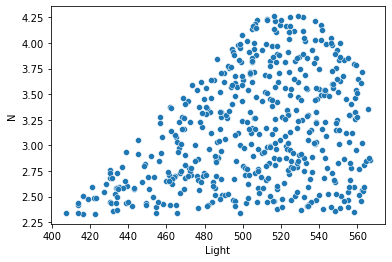

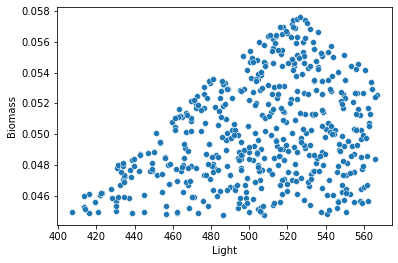

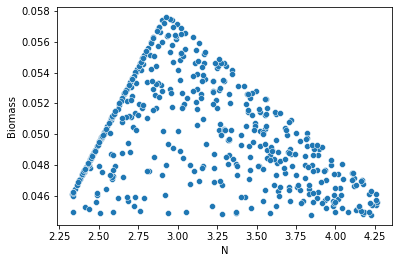

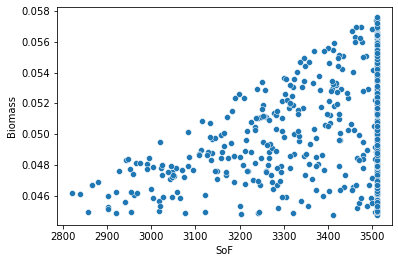

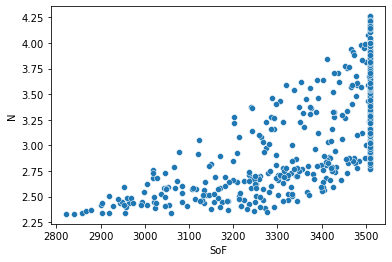

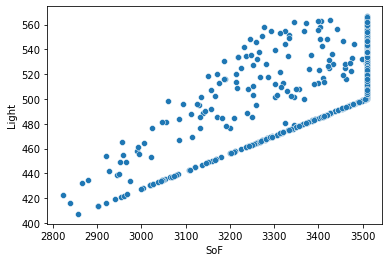

In [10]:

df_c4 = pd.DataFrame(list(zip(res_list_light, res_list_n, res_list_biomass, res_list_sof)), columns=["Light", "N", "Biomass", "SoF"])

sns.scatterplot(x='Light', y='N', data=df_c4)
plt.show()
sns.scatterplot(x='Light', y='Biomass', data=df_c4)
plt.show()
sns.scatterplot(x='N', y='Biomass', data=df_c4)
plt.show()
sns.scatterplot(x='SoF', y='Biomass', data=df_c4)
plt.show()
sns.scatterplot(x='SoF', y='N', data=df_c4)
plt.show()
sns.scatterplot(x='SoF', y='Light', data=df_c4)
plt.show()


In [12]:
"""Writing results to .csv file for later plotting"""

#df_c4.to_csv(f"Sample_{list(res_c4.keys())[0]}_c4.csv", index=True)